In [ ]:
ATTENZIONE:
questo notebook è stato eseguito in ambiente pyspark, utilizzando il cluster e il bucket ad esso collegato(bucketprogetto)
per questo non è possibile rieseguire i comandi a meno che non venga creata una macchina virtuale, un nuovo bucket, si importino i file con gli stessi nomi e nelle stesse cartelle, ecc..
quindi lasciamo il codice alquanto confuso e spieghiamo in generale cosa si prefigge di fare

In [ ]:
questo notebook ha lo scopo di analizzare vari modelli per un dataset grande (circa (175000 x 1000) ,training circa (43000 x 1000))
per varie combinazioni di iperparametri
La parte iniziale riguarda il caricamento dei dati ma anche l'aggiunta di trasformazioni + salvataggio del dataset nuovo su bucket e quindi ricarica dei dati
ecco perchè molti pezzi sono commentati, ovviamente bisogna eseguirli se non si hanno i dati pronti


# Obiettivi:

In [1]:
#!pip install spark-sklearn

Vogliamo considerare, per ognuna delle variabili esplicative quantitative già presenti nel dataset, un insieme di trasformazioni non lineari, alcune monotone altre no, da poter aggiungere in modo da considerare nel modello  anche eventuali relazioni non lineari tra le esplicative e la risposta. Per scegliere quali trasformazioni effettivamente aggiungere al dataset valuteremo l'accuratezza di previsione di una LinearDiscriminantAnalysis che abbia come esplicativa solo la trasformazione che si sta considerando; si deciderà quindi di aggiungere tale trasformazione solo se il classificatore così costruito prevede meglio di un classificatore che preveda sempre la classe più frequente.

Nella cella seguente abbiamo copiato e incollato le funzioni che abbiamo già usato e che useremo in pipeline

In [2]:
from sklearn.base import TransformerMixin

class AbortError(Exception):
    pass


class Sost_Mancanti(TransformerMixin):
    '''
        questa classe e' inseribile in una pipeline di scikitlearn e permette di sostituire eventuali valori mancanti
        di un dataset. i parameetri di inzializzazione 'sost_categoriali' e 'elimina' permettono di modificare il comportamento
        nel seguente modo:
        - se 'sost_categoriali' e' posto uguale a 'True', eventuali valori NaN presenti tra le variabili categoriali del dataset
          verranno sostituiti dalla modalita' che le unita' del dataset assumono piu' frequentemente per tali variabili. In caso contrario le
          variabili categoriali resteranno inalterate.
        - se 'elimina' e' posto pari a 'True' non verra' effettuata alcuna sostitizione ma bensi' verranno eliminate dal dataset tutte le unita' che
          assumono valori NaN per almeno una variabile.

        I valori Nan presenti nelle variabili quantitative verranno sostituiti con la media delle rispettive variabili, sempre che il parametro
        'elimina' non sia 'True'.
    '''
        
    
    def __init__(self,sost_categoriali=False,elimina=False):
        self.sost_categoriali=sost_categoriali
        self.elimina=elimina

    def fit(self,X,y=None):
        
        if self.sost_categoriali:
            self.col_quant=X.select_dtypes(include=['int64','float64']).columns
            self.col_cat=X.select_dtypes(include=['object']).columns
            return self

        else:
            self.col_quant=X.select_dtypes(include=['int64','float64']).columns
            self.col_cat=[]
            return self
                        

    def transform(self,X):
        if self.elimina:
            for col in self.col_quant:
                X=X.drop(D.index([ X[col].isnull()]))
            for col in self.col_cat:
                X=X.drop(D.index([ X[col].isnull()]))
            return 
                
        for col in self.col_quant:
            X.loc[ X[col].isnull(), col] = X[col].mean()
        for col in self.col_cat:
            X.loc[ X[col].isnull(), col] = X[col].value_counts().idxmax()
        return X
        
  
class Elimina_Costanti(TransformerMixin):
    
    '''
        questa classe e' inseribile in una pipeline di scikitlearn e permette di eliminare dal dataset eventuali variabili che assumono lo stesso valore su
        tutte le unita' del dataset e che non sono percio' informative, permettendo cosi' anche di evitare la creazione di valori NaN nel momento
        della standardizzazione (si andrebbe infatti a dividere per la deviazione stardard, che , per tali variabili, sarebbe pari a zero).
    '''

    def __init__(self):
        pass

    def fit(self,X,y=None):
        self.col_costanti=[col for col in X.columns if X[col].nunique()==1]
        return self

    def transform(self,X):
        X=X.drop(self.col_costanti,axis=1)
        return X



class Elimina_Correlate(TransformerMixin):
    '''
        questa classe e' inseribile in una pipeline di scikitlearn e permette di eliminare dal dataset una variabile per ognuna delle coppie di variabili quantitative
        correlate maggiormente di una soglia fissata per default a 0.98 (ma modificabile).Se il parametro 'risparmia_RAM' e' True la funzione fit non calcola all'inizio
        una unica matrice di correlazione per tutto il dataset ciclando poi su di essa per trovare le variabili correlate ma calcola ad ogni passo la correlazione
        per la coppia di variabili prese in considerazione; questo rende piu' lento l'algoritmo ma permette di non saturare la RAM
    '''

    def __init__(self,soglia=0.98, risparmia_RAM=False):
        self.soglia=soglia
        self.risparmia_RAM=risparmia_RAM

    def fit(self,X,y=None):
        iquant=X.select_dtypes(include=['int64','float64']).columns
        self.var_da_togliere=[]
        
        if self.risparmia_RAM:
            for i,ind in enumerate(iquant[:-1]):
                if ind in self.var_da_togliere:
                    continue                     ### se la variabile e' gia' stata tolta avanzo di una riga
                for j in range(i+1,len(iquant)):
                    if abs(X.iloc[:,[i,j]].corr().iloc[1,0])>abs(self.soglia) and not iquant[j] in self.var_da_togliere:
                        self.var_da_togliere.append(iquant[j])
            return self
        
        corr=X[iquant].corr()
        for i,ind in enumerate(corr.index[:-1]):
            if ind in self.var_da_togliere:
                continue                     ### se la variabile e' gia' stata tolta avanzo di una riga
            for j in range(i+1,len(corr.columns)):
                if abs(corr.iloc[i,j])>abs(self.soglia) and not corr.columns[j] in self.var_da_togliere:
                    self.var_da_togliere.append(corr.columns[j])
        return self
        

    def transform(self,X):
        X=X.drop(self.var_da_togliere,axis=1)
        return X
    
                    
                    
class Standardizza(TransformerMixin):
    '''
        questa classe e' inseribile in una pipeline di scikitlearn e permette di standardizzare le variabili del dataset permettendo
        di scegliere se dividere oppure no per la deviazione standard 
    '''

    def __init__(self,s=True):
        self.div_std=s
        

    def fit(self,X,y=None):
        if [col for col in X.select_dtypes(include=['object']).columns]:
            print('il dataset contiene variabili categoriali o non numeriche, impossibile standardizzare..')
            raise AbortError
            
        self.media=X.mean()
        self.std=X.std()
        return self

    def transform(self,X):
        X-=self.media
        if self.div_std:
            X/=self.std
        return X

    def inverse_transform(self,X):
        if self.div_std:
            X*=self.std
        X+=self.media
        return X


class Ottieni_Dummies(TransformerMixin):
    '''
        questa classe e' inseribile in una pipeline di scikitlearn e permette di tresformare le variabili categoriali di un dataset in variabili dummy
    '''

    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        X=pd.get_dummies(X,drop_first=True)
        return X


def elimina_ridondanza(D,col_ridondanti=None):
    
    if not col_ridondanti:
        col_ridondanti=[c for c in D.columns if 'erbbands' in c or 'melbands' in c or\
                             'mfcc' in c or 'gfcc' in c or ('hpcp' in c and not 'thpcp' in c) or\
                             c=='rhythm.beats_count']

    D=D.drop(col_ridondanti,axis=1)
    return X

def elimina_generi(D,gen=['Rock','Pop-Altro','Blues','Ambient','Funk']):
    t=[i for i in D.index if D.loc[i,'GENERE'] in gen]
    D=D.drop(t).reset_index(drop=True)
    return D


# Caricamento e processamento preliminare

### Importiamo i dati

In [3]:

import pandas as pd


In [4]:
from google.cloud import storage
from io import BytesIO

In [5]:
#!pip install tqdm

In [6]:
from tqdm import tqdm

In [7]:
client=storage.Client()
bucket = client.get_bucket('bucketprogetto')
#bucketprogetto era il nome del bucket collegato al cluster 

In [8]:

'''
D=pd.DataFrame()

for name in tqdm([str(a)+'_'+str(a)+b+'.csv' for a in ['a','b','c','d','e','f']+[str(i) for i in range(9)] for b in ['a','b','c','d','e','f']+[str(i) for i in range(9)]]):
    
    blob=storage.blob.Blob('CSV/'+name,bucket)
    
    try:
        content=blob.download_as_string()
    except:
        continue
    T=pd.read_csv(BytesIO(content))
    
    D=pd.concat([D,elimina_generi(T)],ignore_index=True)
'''

"\nD=pd.DataFrame()\n\nfor name in tqdm([str(a)+'_'+str(a)+b+'.csv' for a in ['a','b','c','d','e','f']+[str(i) for i in range(9)] for b in ['a','b','c','d','e','f']+[str(i) for i in range(9)]]):\n    \n    blob=storage.blob.Blob('CSV/'+name,bucket)\n    \n    try:\n        content=blob.download_as_string()\n    except:\n        continue\n    T=pd.read_csv(BytesIO(content))\n    \n    D=pd.concat([D,elimina_generi(T)],ignore_index=True)\n"

In [9]:
#D.shape

### salviamo il dataset semplificato su storage

In [10]:
'''D.to_csv('D.csv',index=False)
blob=bucket.blob('D_senzageneri.csv')
blob.upload_from_filename('D.csv')
'''

"D.to_csv('D.csv',index=False)\nblob=bucket.blob('D_senzageneri.csv')\nblob.upload_from_filename('D.csv')\n"

### carichiamo il dataset

In [11]:
'''blob=bucket.blob('D_senzageneri.csv')
content=blob.download_as_string()
D=pd.read_csv(BytesIO(content))'''

"blob=bucket.blob('D_senzageneri.csv')\ncontent=blob.download_as_string()\nD=pd.read_csv(BytesIO(content))"

In [12]:
#D.shape

### otteniamo indici Training e Test  (No Validation)

### creiamo riferimenti a risposta, esplicative quantitative ed esplicative categoriali

In [13]:
#y , X_quant_corr, X_cat = D['GENERE'].copy() , D.select_dtypes(include=['int64','float64']).copy(), D.select_dtypes(include=['object']).iloc[:,3:].copy()

### Creiamo una pipeline di pre_processamento per le esplicative

In [14]:
from sklearn.pipeline import Pipeline


In [15]:
'''pipe=Pipeline([('mancanti',Sost_Mancanti(sost_categoriali=True)),
               ('costanti',Elimina_Costanti()),
               ('standardizza',Standardizza())])'''

"pipe=Pipeline([('mancanti',Sost_Mancanti(sost_categoriali=True)),\n               ('costanti',Elimina_Costanti()),\n               ('standardizza',Standardizza())])"

### otteniamo le esplicative preprocessate

In [16]:
#X_quant_corr=pipe.fit_transform(X_quant_corr)

In [17]:
#X_quant_corr.shape[1]

In [18]:
#X_quant_corr.isnull().sum().sum()

# Scelta delle trasformazioni


In [19]:
from sklearn.metrics import  accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.dummy import DummyClassifier as DC

In [20]:

import numpy as np
from scipy.stats import norm

In [21]:
from tqdm import tqdm

### Mettiamo in una lista le trasformazioni da considerare

consideriamo la trasformazione seno, esponenziale, densità normale std , cubo e quadrato

In [22]:
#trasformazioni={'sin':np.sin,'exp':np.exp,'norm':norm.pdf,'sq':(lambda x: x**2),'cub':(lambda x: x**3)}

### calcoliamo l'accuratezza di riferimento con cui confrontare l'accuratezza delle trasformazioni

In [23]:
#dummy_acc=accuracy_score(y[idx_val], DC(strategy='most_frequent').fit(X_quant_corr.iloc[idx_train,:],y[idx_train]).predict(X_quant_corr.iloc[idx_val,:]))

In [24]:
#dummy_acc

il classificatore che prevede sempre la classe più frequente ha un'accuratezza del 24.5%...poichè questa soglia è troppo bassa e ci porterebbe ad inserire troppe trasformazioni, la alziamo arbitrariamente a 0.4, in modo da essere sicuri che le trasformazioni che inseriamo nel dataset diano davvero informazione aggiuntiva.

### cerchiamo le trasformazioni che ci interessano

In [25]:
#cl=LDA()

In [26]:
'''tr_tenute=[]
for var in tqdm(X_quant_corr.columns):
    for ntr,tr in trasformazioni.items():
        t=pd.DataFrame(tr(X_quant_corr[var])).rename(columns={var:var+'_'+ntr})
        try:
            acc=accuracy_score(y[idx_val],cl.fit(t.iloc[idx_train,:] ,y[idx_train]).predict(t.iloc[idx_val,:]))
        except:
            continue
        r=pd.concat([t,X_quant_corr[var]],axis=1).corr().iloc[1,0]  ### calcolo correlazione tra trasf e var originale
        if acc>0.4 and not abs(r)>0.9:   ###inserisco solo se la trsformazione non è troppo correlata 
            tr_tenute.append(t)
            '''

"tr_tenute=[]\nfor var in tqdm(X_quant_corr.columns):\n    for ntr,tr in trasformazioni.items():\n        t=pd.DataFrame(tr(X_quant_corr[var])).rename(columns={var:var+'_'+ntr})\n        try:\n            acc=accuracy_score(y[idx_val],cl.fit(t.iloc[idx_train,:] ,y[idx_train]).predict(t.iloc[idx_val,:]))\n        except:\n            continue\n        r=pd.concat([t,X_quant_corr[var]],axis=1).corr().iloc[1,0]  ### calcolo correlazione tra trasf e var originale\n        if acc>0.4 and not abs(r)>0.9:   ###inserisco solo se la trsformazione non \xc3\xa8 troppo correlata \n            tr_tenute.append(t)\n            "

In [27]:
#len(tr_tenute)

In [28]:
#X_tr=pd.concat(tr_tenute,axis=1) ## DataFrame con solo le trasformazioni

### standardizziamo le variabili aggiunte, uniamo il tutto e togliamo le correlazioni

In [29]:
#X_tr=Standardizza().fit(X_tr).transform(X_tr)   ### standardizzo trasformazioni aggiunte

In [30]:
#X_tr.isnull().sum().sum()

In [31]:
'''X_qtr_corr=pd.concat([X_quant_corr,X_tr],axis=1)     ### unisco trasformazioni e var originali in un unico dataset
del X_quant_corr
del X_tr'''

'X_qtr_corr=pd.concat([X_quant_corr,X_tr],axis=1)     ### unisco trasformazioni e var originali in un unico dataset\ndel X_quant_corr\ndel X_tr'

In [32]:
#del tr_tenute

In [33]:
#X_qtr=Elimina_Correlate(soglia=0.9).fit(X_qtr_corr).transform(X_qtr_corr)     ### elimino var correlate dal dataset 

In [34]:
#X_qtr.shape[1], X_qtr_corr.shape[1]

### preprocessiamo anche le variabili categoriali salviamo il dataset definitivo su file in modo da poter ripartire da qui la prossima volta

In [35]:
'''pipe3=Pipeline([('mancanti',Sost_Mancanti(sost_categoriali=True)),
               ('costanti',Elimina_Costanti()),
               ('dummy',Ottieni_Dummies()),
               ('standardizza',Standardizza())])

X_cat=pipe3.fit_transform(X_cat)

D_corr=pd.concat([y,X_qtr_corr,X_cat],axis=1)
D=pd.concat([y,X_qtr,X_cat],axis=1)'''

"pipe3=Pipeline([('mancanti',Sost_Mancanti(sost_categoriali=True)),\n               ('costanti',Elimina_Costanti()),\n               ('dummy',Ottieni_Dummies()),\n               ('standardizza',Standardizza())])\n\nX_cat=pipe3.fit_transform(X_cat)\n\nD_corr=pd.concat([y,X_qtr_corr,X_cat],axis=1)\nD=pd.concat([y,X_qtr,X_cat],axis=1)"

In [36]:
#D_corr.shape

#### salviamo i dataset creati

In [37]:
'''D.to_csv('D1.csv',index=False)
blob=bucket.blob('D.csv')#nome a caso  dove andrò a salvare
blob.upload_from_filename('D1.csv')'''

"D.to_csv('D1.csv',index=False)\nblob=bucket.blob('D.csv')#nome a caso  dove andr\xc3\xb2 a salvare\nblob.upload_from_filename('D1.csv')"

In [38]:
'''D_corr.to_csv('D2.csv',index=False)
blob=bucket.blob('D_corr.csv')
blob.upload_from_filename('D2.csv')''' 

"D_corr.to_csv('D2.csv',index=False)\nblob=bucket.blob('D_corr.csv')\nblob.upload_from_filename('D2.csv')"

#### carichiamo i dataset

In [39]:
blob=bucket.blob('D.csv')
content=blob.download_as_string()
D=pd.read_csv(BytesIO(content))

In [40]:
'''

blob=bucket.blob('D_corr.csv')
content=blob.download_as_string()
D_corr=pd.read_csv(BytesIO(content))'''

"\n\nblob=bucket.blob('D_corr.csv')\ncontent=blob.download_as_string()\nD_corr=pd.read_csv(BytesIO(content))"

In [41]:
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(D.index.values, test_size=0.75, random_state=40)

In [42]:
D.shape

(175506, 1033)

In [43]:
D.shape

(175506, 1033)

In [44]:
len(idx_train),len(idx_test)

(43876, 131630)

In [45]:
#del D

Dividiamo esplicative da risposta

In [46]:
y,X=D['GENERE'],D.iloc[:,1:]

In [47]:
#X_corr=D_corr.iloc[:,1:]

In [48]:
#del D_corr

In [49]:
#X.shape,y.shape,X_corr.shape

In [50]:
X.shape,y.shape

((175506, 1032), (175506,))

In [51]:
#plt.hist(y[idx_test])


###  Ora proviamo a selezionare le variabili più importanti tramite una regressione Lasso sia sul dataset con correlazioni che su quello senza

#### prima però troviamo i migliori LDA possibili sia sul dataset con correlazioni che su quello senza, questo per vere un raffronto sul modello che troveremo dopo aver tolto le variabili tramite la lasso. Vogliamo infatti capire se togliere quelle variabili sia effettivamente vantaggioso

## Dimensione training set : 43876 unita'

In [52]:
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from spark_sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.dummy import DummyClassifier

In [53]:
cvs=KFold(random_state=40) #di default sono 3 splits

## CREIAMO UNA BASELINE

In [ ]:
dc = DummyClassifier()
dc0=GridSearchCV(sc,dc,param_grid={"strategy":["most_frequent","uniform"]},scoring=make_scorer(accuracy_score),cv=cvs)
dc0.fit(X.iloc[idx_train,:],y[idx_train])
max(dc0.cv_results_["mean_test_score"])


In [ ]:
## La baseline non arriva al 25% di accuratezza

## PCA + LDA

In [ ]:
## ho ristretto la griglia dopo una prima stima

In [60]:
pipe=Pipeline([('pca',PCA(whiten=True)),
               ('lda',LDA(solver='eigen'))])
pca_lda=GridSearchCV(sc,pipe,param_grid={'pca__n_components':[100,200,300,400,500,600,700,800,900,1000,1032],'lda__shrinkage':[0,0.01,0.02,0.5,1]},scoring=make_scorer(accuracy_score),cv=cvs)



In [61]:
pca_lda.fit(X.iloc[idx_train,:],y[idx_train])

GridSearchCV(cv=KFold(n_splits=3, random_state=40, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1032], 'lda__shrinkage': [0, 0.01, 0.02, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       sc=<SparkContext master=yarn appName=PySparkShell>,
       scoring=make_scorer(accuracy_score), verbose=0)

In [56]:
pca_lda.cv_results_

{'mean_fit_time': array([ 6.192403  ,  7.6289506 ,  9.58170867, 13.79273931, 17.69491394,
        20.549107  , 25.53360438, 29.16726065,  5.63935328,  6.78140903,
         9.54412405, 12.98745537, 17.47984227, 20.37140171, 24.72460357,
        29.16654929,  5.69890229,  6.78317738,  9.73138404, 13.29314971,
        17.38771534, 20.59424233, 23.0933853 , 28.28355948]),
 'mean_score_time': array([0.23232492, 0.31175073, 0.35736767, 0.46768936, 0.59160868,
        0.63444201, 0.66669798, 0.79927834, 0.21737234, 0.29377699,
        0.37948338, 0.45444496, 0.56038809, 0.59958792, 0.68972437,
        0.82047113, 0.24149958, 0.29353833, 0.39462304, 0.43554163,
        0.47862236, 0.64302198, 0.5268654 , 0.58176994]),
 'mean_test_score': array([0.80962257, 0.82744553, 0.83633421, 0.84080135, 0.84353633,
        0.84811742, 0.85089799, 0.85237943, 0.80923512, 0.82664783,
        0.83729146, 0.84052785, 0.84465311, 0.84720576, 0.84998633,
        0.85265293, 0.80932628, 0.82621479, 0.83656213, 0

In [57]:
max(pca_lda.cv_results_["mean_test_score"])

0.852652930987328

In [74]:
pca_lda.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=1032, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0,
              solver='eigen', store_covariance=False, tol=0.0001))])

In [58]:
pca_lda.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=800, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.01,
              solver='eigen', store_covariance=False, tol=0.0001))])

In [ ]:
############

In [97]:
pipe00=Pipeline([('pca',PCA(whiten=True)),
               ('lda',LDA(solver='eigen'))])
pca_lda00=GridSearchCV(sc,pipe00,param_grid={'pca__n_components':[100, 200, 300, 400, 500, 600, 700,800,900,1000,1032],'lda__shrinkage':[0]},scoring=make_scorer(accuracy_score),cv=cvs)


In [98]:
pca_lda00.fit(X.iloc[idx_train,:],y[idx_train])

GridSearchCV(cv=KFold(n_splits=3, random_state=40, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1032], 'lda__shrinkage': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       sc=<SparkContext master=yarn appName=PySparkShell>,
       scoring=make_scorer(accuracy_score), verbose=0)

## LDA + PCA con solver=svd

In [ ]:
#rifare con più valori di pca per il grafico acc-n_comp
#creare baseline

In [73]:
pipe0=Pipeline([('pca',PCA(whiten=True)),
               ('lda',LDA())])
pca_lda0=GridSearchCV(sc,pipe0,param_grid={'pca__n_components':[800,900,960,980,990,1000,1010,1020,1032]},scoring=make_scorer(accuracy_score),cv=cvs)



In [74]:
pca_lda0.fit(X.iloc[idx_train,:],y[idx_train])

GridSearchCV(cv=KFold(n_splits=3, random_state=40, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [800, 900, 960, 980, 990, 1000, 1010, 1020, 1032]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       sc=<SparkContext master=yarn appName=PySparkShell>,
       scoring=make_scorer(accuracy_score), verbose=0)

In [75]:
pca_lda0.cv_results_

{'mean_fit_time': array([34.50218733, 18.19824235, 19.26414768, 19.99280365, 20.34329502,
        20.29002364, 20.34361076, 20.93585602, 20.54009922]),
 'mean_score_time': array([0.75784206, 0.85208829, 0.89003142, 0.8888127 , 0.91178497,
        0.86921867, 0.87389127, 0.90049974, 0.76232934]),
 'mean_test_score': array([0.8516501 , 0.85304039, 0.8535418 , 0.854066  , 0.85395205,
        0.85335947, 0.85340505, 0.85349622, 0.85324551]),
 'mean_train_score': array([0.86278375, 0.86598595, 0.86780927, 0.86829929, 0.86835627,
        0.86831069, 0.86858419, 0.86893746, 0.86878931]),
 'param_pca__n_components': masked_array(data=[800, 900, 960, 980, 990, 1000, 1010, 1020, 1032],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': ({'pca__n_components': 800},
  {'pca__n_components': 900},
  {'pca__n_components': 960},
  {'pca__n_components': 980},
  {'pca__n_components': 990},

In [76]:
max(pca_lda0.cv_results_["mean_test_score"])

0.8540660041936367

In [77]:
pca_lda0.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=980, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))])

In [82]:
accuracy_score(pca_lda0.best_estimator_.predict(X.iloc[idx_test]),y[idx_test])
#accuratezza sulle prime 20000 unità del test

0.8562637696573729

In [111]:
### rifacciamo la grid per fare il grafico dell' accuratezza al variare del numero di componenti

In [63]:
pipe00=Pipeline([('pca',PCA(whiten=True)),
               ('lda',LDA())])
pca_lda00=GridSearchCV(sc,pipe00,param_grid={'pca__n_components':np.arange(100,800,100)},scoring=make_scorer(accuracy_score),cv=cvs)



In [64]:
pca_lda00.fit(X.iloc[idx_train,:],y[idx_train])

GridSearchCV(cv=KFold(n_splits=3, random_state=40, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': array([100, 200, 300, 400, 500, 600, 700])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       sc=<SparkContext master=yarn appName=PySparkShell>,
       scoring=make_scorer(accuracy_score), verbose=0)

In [65]:
pca_lda00.cv_results_

{'mean_fit_time': array([ 6.8722384 ,  7.6902554 , 11.38646706, 15.08707396, 19.72544066,
        23.46198273, 25.36757636]),
 'mean_score_time': array([0.22618119, 0.28807195, 0.40090569, 0.46444066, 0.54992398,
        0.55858898, 0.48525802]),
 'mean_test_score': array([0.8087565 , 0.82710366, 0.83560489, 0.84036831, 0.84371866,
        0.84647643, 0.84891512]),
 'mean_train_score': array([0.80989609, 0.83004375, 0.84104067, 0.84623712, 0.85153615,
        0.85628817, 0.85934223]),
 'param_pca__n_components': masked_array(data=[100, 200, 300, 400, 500, 600, 700],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': ({'pca__n_components': 100},
  {'pca__n_components': 200},
  {'pca__n_components': 300},
  {'pca__n_components': 400},
  {'pca__n_components': 500},
  {'pca__n_components': 600},
  {'pca__n_components': 700}),
 'rank_test_score': array([7, 6, 5, 4, 3, 2, 1], dtype=int32),
 'split0_test_score':

In [66]:
v1=[100, 200, 300, 400, 500, 600, 700,800,900,960,980,990,1000,1010,1020,1032]
v2=[0.8087565 , 0.82710366, 0.83560489, 0.84036831, 0.84371866,
        0.84647643, 0.84891512,0.8516501 , 0.85304039, 0.8535418 , 0.854066  , 0.85395205,
        0.85335947, 0.85340505, 0.85349622, 0.85324551]

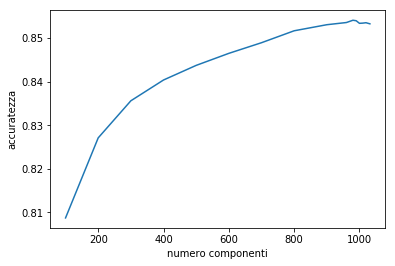

In [67]:
plt.plot(v1,v2)
plt.xlabel('numero componenti')
plt.ylabel('accuratezza')
plt.show()

## MATRICE DI CONFUSIONE

In [85]:
confusion_matrix(y[idx_test],pca_lda0.best_estimator_.predict(X.iloc[idx_test]))

array([[23998,    91,  1990,   604,  1004],
       [   55, 10977,   278,   466,  1685],
       [ 1145,   381, 21892,   375,  1598],
       [  469,   238,   632, 29379,  1897],
       [  763,  1616,  1383,  2250, 26464]])

Normalized confusion matrix


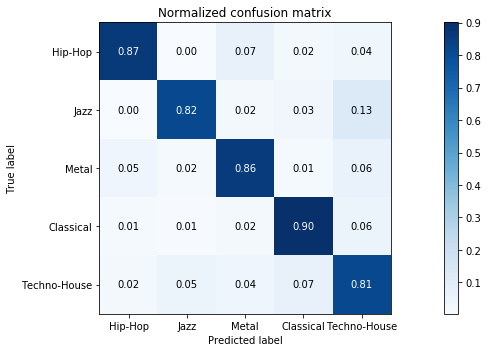

In [109]:

y_pred =pca_lda0.best_estimator_.predict(X.iloc[idx_test])


def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    
        
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")


    fig, ax = plt.subplots(figsize=(15,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
     #        rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)


# Plot normalized confusion matrix
plot_confusion_matrix(y[idx_test],pca_lda0.best_estimator_.predict(X.iloc[idx_test]), classes=set(y[idx_test]),
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
## Il richiamo per una modalità è il numero dei correttamente classificati fratto i veri di quella classe
#La precisione per una modalità è il numero dei correttamente classificati fratto tutti quelli classificati con quella classe

## gli elementi sulla diagonale sono i richiami delle rispettive classi
## la precisione per una classe si calcola come elsulladiag/(sommasucolonna)

##l'isoF1 è 2*(p*r)/(p+r)

## LDA

In [199]:
p=GridSearchCV(sc,LDA(solver="eigen"),param_grid={"shrinkage":np.arange(0.2,-0.01,-0.02)},scoring=make_scorer(accuracy_score),cv=cvs)

In [200]:
p.fit(X.iloc[idx_train,:],y[idx_train])

GridSearchCV(cv=KFold(n_splits=3, random_state=40, shuffle=False),
       error_score='raise',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'shrinkage': array([2.00000e-01, 1.80000e-01, 1.60000e-01, 1.40000e-01, 1.20000e-01,
       1.00000e-01, 8.00000e-02, 6.00000e-02, 4.00000e-02, 2.00000e-02,
       1.11022e-16])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       sc=<SparkContext master=yarn appName=PySparkShell>,
       scoring=make_scorer(accuracy_score), verbose=0)

In [201]:
p.cv_results_

{'mean_fit_time': array([4.56301133, 4.10758932, 3.84608666, 3.75467126, 3.88214127,
        3.762544  , 3.8688666 , 3.71770732, 3.80989035, 3.68389996,
        3.39764961]),
 'mean_score_time': array([0.0734907 , 0.07554197, 0.07387161, 0.07507666, 0.07740466,
        0.07126339, 0.07482473, 0.07188145, 0.08243688, 0.07853103,
        0.06657203]),
 'mean_test_score': array([0.83473881, 0.83603793, 0.83749658, 0.83925153, 0.84105206,
        0.84232838, 0.84344516, 0.8449494 , 0.84622573, 0.84745647,
        0.24810831]),
 'mean_train_score': array([0.84143951, 0.84297794, 0.84426566, 0.84563315, 0.84704622,
        0.84885814, 0.85090938, 0.85275548, 0.8551486 , 0.85780381,
        0.2481083 ]),
 'param_shrinkage': masked_array(data=[0.2, 0.18000000000000002, 0.16000000000000003,
                    0.14000000000000004, 0.12000000000000005,
                    0.10000000000000006, 0.08000000000000007,
                    0.06000000000000008, 0.04000000000000009,
                    0

In [202]:
p.best_estimator_

LinearDiscriminantAnalysis(n_components=None, priors=None,
              shrinkage=0.0200000000000001, solver='eigen',
              store_covariance=False, tol=0.0001)

In [203]:
max(p.cv_results_["mean_test_score"])

0.8474564682286444

In [159]:
accuracy_score(p.best_estimator_.predict(X.iloc[idx_test[:20000]]),y[idx_test[:20000]])
#accuratezza sulle prime 20000 unità del test

0.8505

In [ ]:
## Proviamo LDA con shrinkage=None per vedere se cambia
## uso la grid con un solo parametro per possibilità di replicazione

In [64]:
p1=LDA()

In [65]:
p1.fit(X.iloc[idx_train,:],y[idx_train])

/opt/conda/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [66]:
accuracy_score(p1.predict(X.iloc[idx_test,:][:10000]),y[idx_test][:10000])

0.8558

## RIDGE

In [96]:
r=GridSearchCV(sc,LogisticRegression(fit_intercept=False,solver="saga",multi_class="multinomial",warm_start=True,class_weight="balanced",random_state=40),param_grid={'C':[0.05,0.1,0.2,0.6,1.5,200,1e5]},scoring=make_scorer(accuracy_score),cv=cvs)

In [ ]:
r.fit(X.iloc[idx_train,:],y[idx_train])

GridSearchCV(cv=KFold(n_splits=3, random_state=40, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=40, solver='saga', tol=0.0001, verbose=0,
          warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.05, 0.1, 0.2, 0.6, 1.5, 200, 100000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       sc=<SparkContext master=yarn appName=PySparkShell>,
       scoring=make_scorer(accuracy_score), verbose=0)

In [ ]:
r.cv_results_

{'mean_fit_time': array([112.8649958 , 111.15948439, 112.88175925, 111.42127633,
        112.13075995, 112.21429801, 111.48967568]),
 'mean_score_time': array([0.10594567, 0.11097089, 0.07519507, 0.08216731, 0.0846947 ,
        0.07217232, 0.06845236]),
 'mean_test_score': array([0.82286444, 0.82286444, 0.82286444, 0.82288723, 0.82288723,
        0.82288723, 0.82288723]),
 'mean_train_score': array([0.82837995, 0.82841414, 0.82842553, 0.82841414, 0.82841414,
        0.82841414, 0.82841414]),
 'param_C': masked_array(data=[0.05, 0.1, 0.2, 0.6, 1.5, 200, 100000.0],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': ({'C': 0.05},
  {'C': 0.1},
  {'C': 0.2},
  {'C': 0.6},
  {'C': 1.5},
  {'C': 200},
  {'C': 100000.0}),
 'rank_test_score': array([5, 5, 5, 1, 1, 1, 1], dtype=int32),
 'split0_test_score': array([0.82168741, 0.82168741, 0.82168741, 0.82175578, 0.82175578,
        0.82175578, 0.82175578]),
 'split

In [ ]:
max(r.cv_results_["mean_test_score"])

0.8228872276415352

## PCA + RIDGE

In [ ]:
pipe1=Pipeline([('pca',PCA(whiten=True)),
               ('ridge',LogisticRegression(fit_intercept=False,solver="saga",multi_class="multinomial",warm_start=True,class_weight="balanced",random_state=40))])

pca_ridge=GridSearchCV(sc,pipe1,param_grid={'pca__n_components':range(32,X.shape[1],100),'ridge__C':[0.05,2,200,1e5]},scoring=make_scorer(accuracy_score),cv=cvs)


In [ ]:
pca_ridge.fit(X.iloc[idx_train,:],y[idx_train])

/opt/conda/anaconda/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=KFold(n_splits=3, random_state=40, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('ridge', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=40, solver='saga', tol=0.0001, verbose=0,
          warm_start=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [32, 132, 232, 332, 432, 532, 632, 732, 832, 932], 'ridge__C': [0.05, 2, 200, 100000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       sc=<SparkContext master=yarn appName=PySparkShell>,
       scoring=make_scorer(accuracy_score), verbose=0)

In [64]:
pca_ridge.cv_results_

{'mean_fit_time': array([  8.56166371,   8.57385222,   8.83586295,   8.83140095,
         22.09583728,  21.83433565,  22.34416135,  22.24869839,
         34.95788169,  35.85410237,  35.20329698,  35.67124399,
         48.9748071 ,  48.56030265,  49.40970333,  49.0133884 ,
         62.68388971,  63.6579361 ,  63.10169363,  63.14547865,
         77.80790194,  76.98433868,  78.35658503,  78.54686642,
         90.84930793,  91.10645334,  90.58969776,  92.20552262,
        106.07869339, 104.5127244 , 106.02823369, 106.36904494,
        100.45368997, 102.35714706, 102.55371229,  99.90800667,
        113.70990864, 110.00945075, 111.22995623, 112.28901728]),
 'mean_score_time': array([0.16662963, 0.17775043, 0.16837533, 0.17364144, 0.23325404,
        0.25015998, 0.22549367, 0.2278107 , 0.27296972, 0.31280835,
        0.27876377, 0.27037732, 0.36860228, 0.35769256, 0.35522493,
        0.34286571, 0.42888141, 0.49576664, 0.45229101, 0.46087098,
        0.51260734, 0.49558425, 0.52659933, 0.5078

In [65]:
max(pca_ridge.cv_results_["mean_test_score"])

0.850168657124624

In [66]:
pca_ridge.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=832, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('ridge', LogisticRegression(C=0.05, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=40, solver='saga', tol=0.0001, verbose=0,
          warm_start=True))])

In [ ]:
## rifacciaamo la ridge campionando maggiormente tra 800 e 900 cp

In [67]:
pipe1=Pipeline([('pca',PCA(whiten=True)),
               ('ridge',LogisticRegression(fit_intercept=False,solver="saga",multi_class="multinomial",warm_start=True,class_weight="balanced",random_state=40))])

pca_ridge1=GridSearchCV(sc,pipe1,param_grid={'pca__n_components':range(780,920,10),'ridge__C':[0.05,2]},scoring=make_scorer(accuracy_score),cv=cvs)


In [ ]:
pca_ridge1.fit(X.iloc[idx_train,:],y[idx_train])

GridSearchCV(cv=KFold(n_splits=3, random_state=40, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('ridge', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=40, solver='saga', tol=0.0001, verbose=0,
          warm_start=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910], 'ridge__C': [0.05, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       sc=<SparkContext master=yarn appName=PySparkShell>,
       scoring=make_scorer(accuracy_score), verbose=0)

In [ ]:
pca_ridge1.cv_results_

{'mean_fit_time': array([114.13880293, 113.98353998, 113.42727701, 113.01315633,
        115.71227638, 115.99496627, 115.77176372, 117.93987497,
        119.3805987 , 117.8400503 , 102.03172731, 100.92102806,
        102.05239296, 102.24349729, 103.49170065, 103.12941766,
        105.18932533, 104.03287609, 105.58795659, 104.84977357,
        106.4919823 , 106.48724341, 106.9984204 , 107.33876006,
        109.9896094 , 108.0324436 , 109.570738  , 109.41887101]),
 'mean_score_time': array([0.67344673, 0.68616072, 0.75547004, 0.67897836, 0.63602599,
        0.71137404, 0.6504186 , 0.73128271, 0.72012599, 0.71970733,
        0.74032203, 0.71407127, 0.74406163, 0.77477105, 0.68848165,
        0.813272  , 0.67481995, 0.78119365, 0.74641109, 0.77034028,
        0.77649132, 0.68910193, 0.76580826, 0.76426029, 0.81305035,
        0.73928006, 0.65109436, 0.74131497]),
 'mean_test_score': array([0.84859604, 0.84802626, 0.84964445, 0.84859604, 0.84914304,
        0.84927979, 0.84916583, 0.8489835

In [72]:
max(pca_ridge1.cv_results_["mean_test_score"])

0.8503509891512444

In [73]:
pca_ridge1.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=820, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('ridge', LogisticRegression(C=0.05, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=40, solver='saga', tol=0.0001, verbose=0,
          warm_start=True))])

## LASSO

In [ ]:
l=GridSearchCV(sc,LogisticRegression(fit_intercept=False,solver="saga",penalty="l1",multi_class="multinomial",warm_start=True,class_weight="balanced",random_state=40),param_grid={'C':[0.01,0.05,0.1,0.5,1,3,5]},cv=cvs,scoring=make_scorer(accuracy_score))

In [ ]:
l.fit(X.iloc[idx_train,:],y[idx_train])

GridSearchCV(cv=KFold(n_splits=3, random_state=40, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=40, solver='saga', tol=0.0001, verbose=0,
          warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       sc=<SparkContext master=yarn appName=PySparkShell>,
       scoring=make_scorer(accuracy_score), verbose=0)

In [ ]:
l.cv_results_

{'mean_fit_time': array([239.87324492, 311.89896925, 300.26413862, 291.7510554 ,
        291.36158689, 300.58888761, 297.67239006]),
 'mean_score_time': array([0.1018788 , 0.10065071, 0.07656527, 0.08165932, 0.07655644,
        0.07625238, 0.06400927]),
 'mean_test_score': array([0.82051691, 0.83029447, 0.83138846, 0.83200383, 0.83214058,
        0.83225454, 0.83225454]),
 'mean_train_score': array([0.82347979, 0.83625442, 0.83798657, 0.83906917, 0.83935406,
        0.83947941, 0.8395136 ]),
 'param_C': masked_array(data=[0.01, 0.05, 0.1, 0.5, 1, 3, 5],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': ({'C': 0.01},
  {'C': 0.05},
  {'C': 0.1},
  {'C': 0.5},
  {'C': 1},
  {'C': 3},
  {'C': 5}),
 'rank_test_score': array([7, 6, 5, 4, 3, 1, 1], dtype=int32),
 'split0_test_score': array([0.82079858, 0.82941337, 0.83050732, 0.83160126, 0.83187474,
        0.83201149, 0.83201149]),
 'split0_train_score': arra

In [150]:
max(l.cv_results_["mean_test_score"])

0.8322545355091622

In [151]:
l.best_estimator_

LogisticRegression(C=3, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=40, solver='saga', tol=0.0001, verbose=0,
          warm_start=True)

## PCA + LASSO

In [ ]:
pipe2=Pipeline([('pca',PCA(whiten=True)),
               ('lasso',LogisticRegression(fit_intercept=False,solver="saga",penalty='l1',multi_class="multinomial",warm_start=True,class_weight="balanced",random_state=40))])

pca_lasso=GridSearchCV(sc,pipe2,param_grid={'pca__n_components':range(10,X.shape[1]-500,40),'lasso__C':[0.05,2,1e5],'lasso__class_weight':[None,"balanced"]},scoring=make_scorer(accuracy_score))


In [ ]:
pca_lasso.fit(X.iloc[idx_train,:],y[idx_train])

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('lasso', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=40, solver='saga', tol=0.0001, verbose=0,
          warm_start=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [10, 50, 90, 130, 170, 210, 250, 290, 330, 370, 410, 450, 490, 530], 'lasso__class_weight': [None, 'balanced'], 'lasso__C': [0.05, 2, 100000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       sc=<SparkContext master=yarn appName=PySparkShell>,
       scoring=make_scorer(accuracy_score), verbose=0)

In [ ]:
pca_lasso.cv_results_

{'mean_fit_time': array([  6.58879296,  15.89841135,  24.42942238,  31.0088559 ,
         40.63648136,  49.27992972,  61.78216672,  74.23528965,
         88.65011628, 102.08132998, 120.21582357, 132.49315429,
        147.65239263, 160.75267609,   6.6288813 ,  15.82506291,
         24.06807566,  31.59432737,  39.90563838,  50.38453762,
         60.51824466,  74.24831096,  87.88278619, 102.99543405,
        117.90694133, 133.47404901, 145.0253466 , 161.6949327 ,
          6.71532003,  16.95604467,  26.77706726,  35.499657  ,
         46.57971891,  55.62436064,  67.24716894,  75.95985436,
         89.31928825,  98.25859292, 113.22013529, 124.00471266,
        138.8244706 , 149.04242595,   6.59207106,  17.28755538,
         27.51485856,  36.10664972,  46.60365931,  55.67255004,
         67.30598823,  75.80473741,  89.57990289,  98.33617274,
        113.18212636, 123.28853138, 138.75613499, 148.41634329,
          6.87162534,  17.68525632,  28.41836802,  39.42652957,
         50.51877666,  

In [ ]:
max(pca_lasso.cv_results_["mean_test_score"])

0.85057890418452

In [ ]:
pca_lasso.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=530, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('lasso', LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l1', random_state=40, solver='saga',
          tol=0.0001, verbose=0, warm_start=True))])

In [68]:
pipe2=Pipeline([('pca',PCA(whiten=True)),
               ('lasso',LogisticRegression(fit_intercept=False,solver="saga",penalty='l1',multi_class="multinomial",warm_start=True,class_weight="balanced",random_state=40))])

pca_lasso1=GridSearchCV(sc,pipe2,param_grid={'pca__n_components':[500,520,540,560,600,700,800],'lasso__C':[0.05,2,1e5],'lasso__class_weight':[None,"balanced"]},scoring=make_scorer(accuracy_score),cv=cvs)


In [ ]:
pca_lasso1.fit(X.iloc[idx_train,:],y[idx_train])

In [ ]:
pca_lasso1.best_estimator_

## In definitiva i modelli migliori sono LDA e PCA+LDA
## Ora adattiamo una lasso e teniamo le variabili i cui coefficienti sono diversi da zero

In [ ]:
# l è un'istanza della classe lasso

In [152]:
(l.best_estimator_.coef_[0]==0).sum()

1

In [120]:
accuracy_score(l.best_estimator_.coef_<0.05,l.best_estimator_.coef_>-0.05)


0.0

In [124]:
l.best_estimator_.coef_[0]

array([-0.08927208, -0.01010742,  0.00896678, ..., -0.01353914,
        0.00284145, -0.00599544])

In [54]:
jk=LogisticRegression(fit_intercept=False,solver="saga",penalty="l1",multi_class="multinomial",warm_start=True,class_weight="balanced",random_state=40,C=0.001)


In [55]:
jk.fit(X.iloc[idx_train,:],y[idx_train])

/opt/conda/anaconda/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=40, solver='saga', tol=0.0001, verbose=0,
          warm_start=True)

In [56]:
accuracy_score(jk.predict(X.iloc[idx_test[:20000]]),y[idx_test[:20000]])

0.7874

In [37]:
jk.coef_

array([[-0.13053332,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [57]:
col_lasso=[NOME for NOME,w in {nome:[k[i] for k in jk.coef_] for i,nome in enumerate(X.columns)}.items() if any(w)]
#restituisce i nomi delle colonne che hanno almeno un coefficiente diverso da zero
len(col_lasso)

225

In [58]:
dizio={sum(abs(b) for b in list):name for name,list in {nome:[k[i] for k in jk.coef_] for i,nome in enumerate(X.columns)}.items() if any(list)}
#dizionario con chiavi la somma dei coefficienti in valore assoluto(si spera non ce ne siano 2 uguali data la precisione) e con valori il nome delle variabili

(array([1.15736714, 1.27542987, 0.66713425, 0.66034663, 1.41321833,
        1.4076768 , 1.20769003, 0.99865771, 2.08630193, 0.47456279]),
 array([  0. ,  22.4,  44.8,  67.2,  89.6, 112. , 134.4, 156.8, 179.2,
        201.6, 224. ]),
 <a list of 10 Patch objects>)

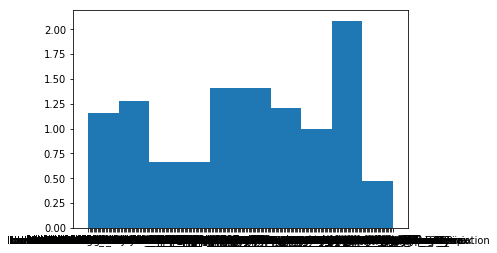

In [46]:
plt.hist(dizio.values(),weights=dizio.keys())

In [59]:
dizio

{0.00042504987335262025: 'lowlevel.barkbands.dmean.6',
 0.0006713634053913806: 'tonal.hpcp.var.3',
 0.0007185182765048143: 'tonal.hpcp.median.7',
 0.0007938397533549231: 'lowlevel.spectral_contrast_coeffs.max.5',
 0.0010967951910380105: 'tonal.hpcp.median.27',
 0.0011441159352432373: 'lowlevel.spectral_spread.min',
 0.0011594000409584197: 'lowlevel.barkbands.median.13_sin',
 0.0011992883625023718: 'tonal.thpcp.21',
 0.0019328794324121605: 'lowlevel.spectral_contrast_valleys.dvar2.1',
 0.002071195954185004: 'lowlevel.erbbands.dmean.12',
 0.0021024674533294437: 'lowlevel.spectral_contrast_valleys.dmean2.4_sin',
 0.002350043979226656: 'lowlevel.erbbands.max.14',
 0.0025067197916904113: 'lowlevel.barkbands.median.14_sin',
 0.003208774499848502: 'tonal.hpcp.median.28',
 0.0034974665321574113: 'lowlevel.melbands_flatness_db.dvar_sin',
 0.0036551606410802325: 'lowlevel.spectral_entropy.var',
 0.004010838625496092: 'tonal.thpcp.8',
 0.004585629075979916: 'lowlevel.melbands_spread.dmean',
 0.00

In [60]:
sorted(dizio.items(),reverse=True)

[(0.3410404905396907, 'tonal.chords_strength.dmean'),
 (0.3148458373665902, 'lowlevel.average_loudness_sq'),
 (0.2574024996480387, 'rhythm.beats_loudness_band_ratio.dmean.0'),
 (0.24761247276498344, 'rhythm.onset_rate'),
 (0.23355981279232524, 'rhythm.beats_loudness_band_ratio.dmean2.0_sin'),
 (0.19223145274160863, 'tonal.chords_changes_rate'),
 (0.1757629816704825, 'rhythm.bpm_histogram_first_peak_weight.max'),
 (0.172672248707917, 'lowlevel.spectral_complexity.dvar'),
 (0.17239113487264485, 'lowlevel.silence_rate_60dB.dmean_sin'),
 (0.1602898214714658, 'lowlevel.spectral_complexity.var'),
 (0.15704725389141946, 'lowlevel.spectral_contrast_coeffs.var.2_sin'),
 (0.156552772326071, 'lowlevel.spectral_centroid.dvar_sin'),
 (0.15589193571946972, 'rhythm.beats_loudness_band_ratio.dmean.4'),
 (0.14203787521293165, 'lowlevel.melbands_flatness_db.min'),
 (0.13479096539666563, 'lowlevel.spectral_complexity.mean'),
 (0.13286749458300245, 'lowlevel.spectral_contrast_coeffs.dmean.1'),
 (0.1317531

In [66]:
var=[i[1] for i in sorted(dizio.items(),reverse=True)]
altezze=[i[0] for i in sorted(dizio.items(),reverse=True)]
var

['tonal.chords_strength.dmean',
 'lowlevel.average_loudness_sq',
 'rhythm.beats_loudness_band_ratio.dmean.0',
 'rhythm.onset_rate',
 'rhythm.beats_loudness_band_ratio.dmean2.0_sin',
 'tonal.chords_changes_rate',
 'rhythm.bpm_histogram_first_peak_weight.max',
 'lowlevel.spectral_complexity.dvar',
 'lowlevel.silence_rate_60dB.dmean_sin',
 'lowlevel.spectral_complexity.var',
 'lowlevel.spectral_contrast_coeffs.var.2_sin',
 'lowlevel.spectral_centroid.dvar_sin',
 'rhythm.beats_loudness_band_ratio.dmean.4',
 'lowlevel.melbands_flatness_db.min',
 'lowlevel.spectral_complexity.mean',
 'lowlevel.spectral_contrast_coeffs.dmean.1',
 'tonal.chords_strength.min',
 'lowlevel.average_loudness',
 'lowlevel.spectral_complexity.dvar_sin',
 'lowlevel.spectral_contrast_coeffs.dvar.1',
 'lowlevel.barkbands.median.16_sin',
 'lowlevel.erbbands_crest.dmean',
 'lowlevel.spectral_contrast_coeffs.var.3_sin',
 'lowlevel.barkbands.median.16',
 'rhythm.danceability_sin',
 'lowlevel.barkbands.median.15_sin',
 'lowl

In [70]:
sum(dizio.keys())

11.348385484450048

<Container object of 5 artists>

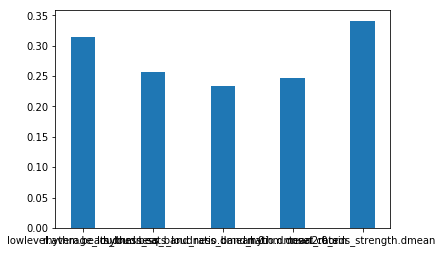

In [79]:
totale=sum(dizio.keys())
var=[i[1] for i in sorted(dizio.items(),reverse=True)[:5]]
altezze=[i[0] for i in sorted(dizio.items(),reverse=True)[:5]]

plt.bar(var,altezze,align="center",width=0.35)


In [58]:
altezze=[i[0] for i in sorted(dizio.items(),reverse=True)[:5]]


TypeError: 'int' object has no attribute '__getitem__'

### Rifacciamo la stessa cosa con la libreria sklearn.feature_selection 

In [30]:
from sklearn.feature_selection import SelectFromModel

In [31]:
kj=LogisticRegression(fit_intercept=False,solver="saga",penalty="l1",multi_class="multinomial",warm_start=True,class_weight="balanced",random_state=40,C=0.001)
kj.fit(X.iloc[idx_train,:],y[idx_train])

/opt/conda/anaconda/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=40, solver='saga', tol=0.0001, verbose=0,
          warm_start=True)

In [32]:
model=SelectFromModel(kj, prefit=True)
X_new = model.transform(X.iloc[idx_train,:])

In [48]:
X_new.shape

(43876, 225)

In [49]:
X_new

array([[ 0.72906434,  0.30807798, -0.40233248, ..., -0.30046189,
        -0.76315729, -0.34173983],
       [-1.82821164, -0.92846671,  1.37843465, ..., -1.00476506,
         0.67450486, -0.65055452],
       [-1.93347114, -0.4473279 , -0.6685697 , ..., -1.43387103,
         0.95987585, -0.39567469],
       ...,
       [ 0.89312846,  1.45977589, -0.46881345, ...,  1.63526556,
        -0.20801931, -0.46140602],
       [ 0.68653409,  0.3206533 , -0.39651549, ..., -0.08500286,
         0.97732977, -0.38535856],
       [-1.18005553, -0.20064604, -0.01074839, ..., -0.83356042,
         0.7733843 ,  0.20508542]])

## Boxplot sul training 

In [141]:
X[y=="Classical"]

,lowlevel.average_loudness,lowlevel.barkbands.dmean.0,lowlevel.barkbands.dmean.1,lowlevel.barkbands.dmean.10,lowlevel.barkbands.dmean.11,lowlevel.barkbands.dmean.12,lowlevel.barkbands.dmean.13,lowlevel.barkbands.dmean.14,lowlevel.barkbands.dmean.15,lowlevel.barkbands.dmean.16,...,tonal.key_key_C,tonal.key_key_C#,tonal.key_key_D,tonal.key_key_D#,tonal.key_key_E,tonal.key_key_F,tonal.key_key_F#,tonal.key_key_G,tonal.key_key_G#,tonal.key_scale_minor
1,-1.933478,-0.252938,-0.769658,-0.767473,-0.828734,-0.567508,-0.877682,-0.775922,-0.492656,-0.323093,...,-0.326029,-0.245245,-0.328163,-0.257115,3.945435,-0.425187,-0.195689,-0.272166,-0.238888,-1.032949
12,-1.561443,-0.252196,-0.766901,-1.100435,-1.165131,-0.959365,-0.841397,-0.920995,-0.778780,-0.991258,...,-0.326029,-0.245245,-0.328163,-0.257115,-0.253456,-0.425187,-0.195689,3.674202,-0.238888,-1.032949
20,0.025669,-0.246448,-0.754854,-0.809402,-0.949452,0.403677,-0.723800,-0.406159,-0.707008,-0.811454,...,-0.326029,-0.245245,-0.328163,-0.257115,3.945435,-0.425187,-0.195689,-0.272166,-0.238888,0.968097
22,0.695776,-0.252199,-0.738517,0.192666,0.933054,-0.097670,0.458684,-0.011114,-0.204984,-0.198566,...,-0.326029,-0.245245,-0.328163,-0.257115,-0.253456,-0.425187,-0.195689,3.674202,-0.238888,0.968097
23,-0.328220,-0.209634,-0.617558,0.322618,-0.481548,-0.567403,-0.025168,0.261256,-0.354897,-0.143807,...,-0.326029,-0.245245,-0.328163,3.889284,-0.253456,-0.425187,-0.195689,-0.272166,-0.238888,-1.032949
24,-0.403754,-0.191243,0.229714,-0.521394,-0.879364,-0.838972,1.140033,0.013459,1.933514,0.130400,...,3.067198,-0.245245,-0.328163,-0.257115,-0.253456,-0.425187,-0.195689,-0.272166,-0.238888,-1.032949
31,-0.037093,-0.252802,-0.763122,-0.058935,-0.955006,0.092924,-0.062920,-0.751057,0.822206,1.134482,...,-0.326029,-0.245245,-0.328163,-0.257115,-0.253456,-0.425187,-0.195689,-0.272166,-0.238888,-1.032949
35,0.250347,-0.232370,-0.637411,2.653680,0.434309,0.502723,1.119830,0.371545,0.241938,-1.075317,...,-0.326029,-0.245245,-0.328163,-0.257115,-0.253456,-0.425187,-0.195689,-0.272166,-0.238888,0.968097
36,-1.859063,-0.242266,-0.763860,-0.678696,-0.700260,-0.678084,-0.246393,-0.583844,-0.853334,-1.068188,...,-0.326029,-0.245245,-0.328163,3.889284,-0.253456,-0.425187,-0.195689,-0.272166,-0.238888,-1.032949
40,-1.723454,-0.252569,-0.762573,0.585290,0.642320,1.165259,1.384593,0.470450,-0.364627,-0.273674,...,-0.326029,-0.245245,-0.328163,3.889284,-0.253456,-0.425187,-0.195689,-0.272166,-0.238888,-1.032949


In [118]:
xjazz,xclassical,xmetal,xtechnohouse,xhiphop=X[y=="Jazz"],X[y=="Classical"],X[y=="Metal"],X[y=="Techno-House"],X[y=="Hip-Hop"]

In [119]:
l1=len(xjazz['tonal.chords_strength.dmean'])
l2=len(xclassical['tonal.chords_strength.dmean'])
l3=len(xmetal['tonal.chords_strength.dmean'])
l4=len(xtechnohouse['tonal.chords_strength.dmean'])
l5=len(xhiphop['tonal.chords_strength.dmean'])
l1,l2,l3,l4,l5

(33867, 36947, 43501, 43133, 18058)

## BOXPLOTS

In [ ]:
VARIABILE CHE SPIEGA DI PIù MARGINALMENTE

/opt/conda/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


[Text(0,0,u"['Jazz']"),
 Text(0,0,u"['Classical']"),
 Text(0,0,u"['Techno-House']"),
 Text(0,0,u"['Hip-Hop']"),
 Text(0,0,u"['Metal']")]

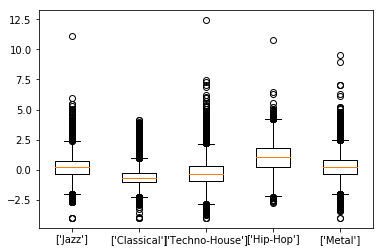

In [143]:
fig,ax=plt.subplots()
ax.boxplot([X[y=="Jazz"]['tonal.chords_strength.dmean'],X[y=="Classical"]['tonal.chords_strength.dmean'],X[y=="Techno-House"]['tonal.chords_strength.dmean'],X[y=="Hip-Hop"]['tonal.chords_strength.dmean'],X[y=="Metal"]['tonal.chords_strength.dmean']])
ax.set_xticklabels([['Jazz'],['Classical'],["Techno-House"],["Hip-Hop"],["Metal"]])

In [ ]:
VARIABILE CHE SPIEGA MENO MARGINALMENTE

[Text(0,0,u"['Jazz']"),
 Text(0,0,u"['Classical']"),
 Text(0,0,u"['Techno-House']"),
 Text(0,0,u"['Hip-Hop']"),
 Text(0,0,u"['Metal']")]

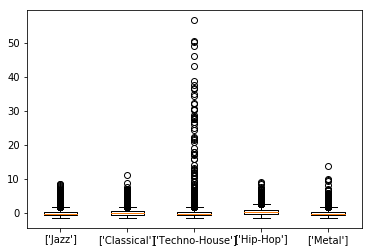

In [144]:
fig,ax=plt.subplots()
ax.boxplot([X[y=="Jazz"]['lowlevel.barkbands.dmean.6'],X[y=="Classical"]['lowlevel.barkbands.dmean.6'],X[y=="Techno-House"]['lowlevel.barkbands.dmean.6'],X[y=="Hip-Hop"]['lowlevel.barkbands.dmean.6'],X[y=="Metal"]['lowlevel.barkbands.dmean.6']])
ax.set_xticklabels([['Jazz'],['Classical'],["Techno-House"],["Hip-Hop"],["Metal"]])